***Import Libraries***

In [1]:
"""This program linearizes 3R planar dyanmics using koopman theory and autoencoder to map"""
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import scipy.io
import torch

# bilinear Koopman
from core.koopman_core_linear import KoopDNN, KoopmanNet, KoopmanNetCtrl
from models.koop_model import model_matricies,lift
from core.util import fit_standardizer
from sklearn import preprocessing

# forward map neural net
from core.neural_fwd_map import map_Net
from models.neural_jacob_map import neural_jacobian, neural_jacobian_dot
# controllability
from core.util import Output_Con
import control as ct


## import paths
from paths.paths import path_pars, path_pars_2D

## extra libraries
import numpy as np
import scipy as sp
from scipy import sparse
import random


In [2]:
## define paths
robot = '5R'
nature = 'linear'
modality = '3D'

robot_type_load = robot +'/' + modality # for data load0
robot_type = robot +'/'+ nature +'/' + modality # for saving purposes

train = True
mass_var = False
standardize = True


if mass_var == True:
    file_data = 'dynamics/Dataset_MATLAB/' + robot_type_load +'/data_mass_var.mat'
else:
    file_data = 'dynamics/Dataset_MATLAB/' + robot_type_load +'/data.mat'
    

    
file_data_fwd = 'dynamics/Dataset_MATLAB/' + robot_type_load +'/data_fw.mat'



In [3]:
file_data

'dynamics/Dataset_MATLAB/5R/3D/data.mat'

### Load Data

In [4]:
data = scipy.io.loadmat(file_data)
data_fw = scipy.io.loadmat(file_data_fwd)

X_end = np.array(data['X_end'], dtype = 'float64')
X_full = np.array(data['X'], dtype = 'float64')
U_full = np.array(data['tau'], dtype = 'float64')

X_end_fw = np.array(data_fw['X_end_fw'], dtype = 'float64')
X_fw = np.array(data_fw['X_fw'], dtype = 'float64')

print(X_end.shape, X_full.shape,U_full.shape)

(200, 1001, 3) (200, 1001, 10) (200, 1000, 5)


In [5]:
np.sum(np.sum(np.isnan(X_end))), np.sum(np.sum(np.isnan(U_full))), np.sum(np.sum(np.isnan(X_full)))

(0, 0, 0)

***Simulation Parameters***

In [6]:
dt = float(data['dt']) #time step
num_snaps = int(data['num_snaps']) # no. of snapshots
num_traj = int(data['num_traj']) #no of trajectories
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = int(0.75*num_traj) # no. of training examples
num_val = num_traj-num_train # no of testing examples
num_traj = num_train+num_val #no of trajectories
num_states = X_full.shape[2] # no. of states
num_joints = int(num_states/2)
num_inputs = U_full.shape[2] # no. of inputs
num_states_cart = int(X_end.shape[2])

In [7]:
dt, num_snaps, num_traj, num_states, num_inputs

(0.005, 1000, 200, 10, 5)

***Plotting the trajectories***

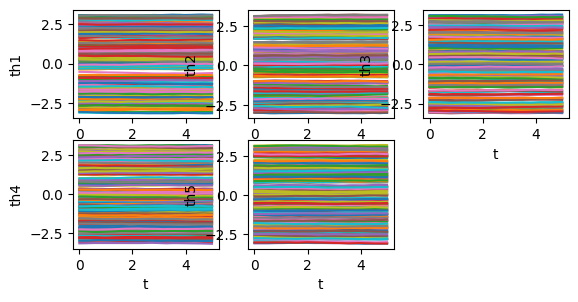

In [8]:
"""Training dataset visualization"""
#theta evolution
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.xlabel("t")
    plt.ylabel("th"+str(i+1))
    for j in range(num_traj):
        plt.plot(T,X_full[j,:,i])

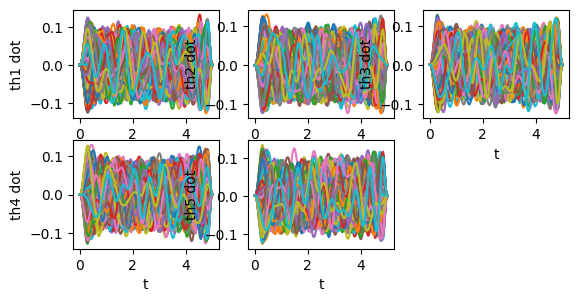

In [9]:
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.xlabel("t")
    plt.ylabel("th"+str(i+1)+ ' dot')
    for j in range(num_traj):
        plt.plot(T,X_full[j,:,i+int(num_joints)])

In [10]:
#x and y positions of the end effector
# %matplotlib widget
# ax = plt.axes(projection='3d')
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_zlabel("z")
# for i in range(num_traj):
#     ax.plot3D(X_end[i,:,0],X_end[i,:,1],X_end[i,:,2])
    
# plt.axis('equal')

(-1.4082256410463365,
 1.2162615275538926,
 -1.2879232904449895,
 1.3425861283208387)

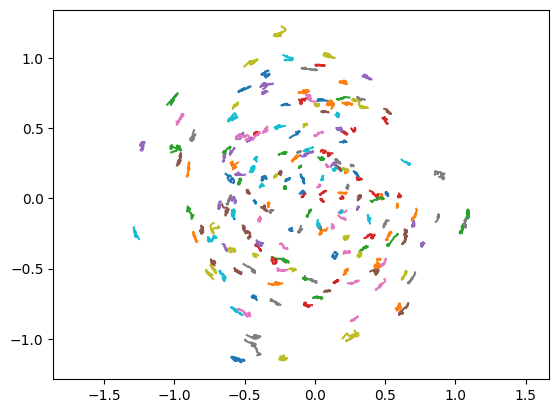

In [11]:
for i in range(num_traj):
    plt.plot(X_end[i,:,0],X_end[i,:,1])
    
plt.axis('equal')

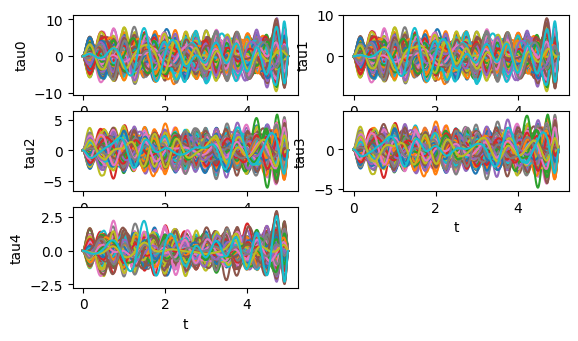

In [12]:
for i in range(num_inputs):
    plt.subplot(4,2,i+1)
    plt.xlabel("t")
    plt.ylabel("tau"+str(i))
    for j in range(num_traj):
        plt.plot(T[:-1],U_full[j,:,i])

***Training and validation datasets***

In [13]:
# split training and vaidation datasets
xs_train, us_train = X_full[:num_train,:,:],U_full[:num_train,:,:]
xs_val, us_val = X_full[num_train:,:,:],U_full[num_train:,:,:]

In [14]:
# import scipy.io
# Data_set = {"x_end": X_end, "X_full": X_full}
# scipy.io.savemat("Data_set.mat",Data_set)

In [15]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

***Model Training***

In [16]:
net_params = {}
net_params['state_dim'] = num_states
net_params['ctrl_dim'] = num_inputs
net_params['encoder_hidden_width'] = 30 # 30
net_params['encoder_hidden_depth'] = 3  # 2
net_params['encoder_output_dim'] = 20   # 20
net_params['optimizer'] = 'adam'
net_params['activation_type'] = 'tanh'
net_params['lr'] = 5e-4 # 5e-4
net_params['epochs'] = 100
net_params['batch_size'] = 128
net_params['lifted_loss_penalty'] = 0.4 
net_params['l2_reg'] = 0.00       
net_params['l1_reg'] = 0.00
net_params['first_obs_const'] = True
net_params['override_C'] = True # this makes the state a part of lifetd state
net_params['dt'] = dt

In [17]:
                                                    
if mass_var == True:
    file_koop = 'saved_models/'+robot_type+'/koop_arch_con_mass_var.pth'
else:
    file_koop = 'saved_models/'+robot_type+'/koop_arch_con.pth'
    
standardizer_u_kdnn = fit_standardizer(us_train, preprocessing.StandardScaler(with_mean = True))
# standardizer_x_kdnn = fit_standardizer(xs_train, preprocessing.StandardScaler(with_mean=False))

if train == True:
    
    if standardize:
        net = KoopmanNetCtrl(net_params, standardizer_u=standardizer_u_kdnn)
    else:
        net = KoopmanNetCtrl(net_params)
    model_koop_dnn = KoopDNN(net)
    model_koop_dnn.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn.model_pipeline(net_params)
    model_koop_dnn.construct_koopman_model()
    torch.save(model_koop_dnn,file_koop)
else:
    model_koop_dnn = torch.load(file_koop)


Epoch   1: train loss: 0.9449263811, validation loss: 0.7309015038
Epoch   2: train loss: 0.6242583990, validation loss: 0.5597236534
Epoch   3: train loss: 0.4938183725, validation loss: 0.4776932259
Epoch   4: train loss: 0.4370649457, validation loss: 0.4286975059
Epoch   5: train loss: 0.3857692182, validation loss: 0.3749900361
Epoch   6: train loss: 0.3315728903, validation loss: 0.3186196145
Epoch   7: train loss: 0.2774838507, validation loss: 0.2642558086
Epoch   8: train loss: 0.2269413471, validation loss: 0.2144261114
Epoch   9: train loss: 0.1837703586, validation loss: 0.1738379506
Epoch  10: train loss: 0.1501386464, validation loss: 0.1433902071
Epoch  11: train loss: 0.1257104278, validation loss: 0.1216130611
Epoch  12: train loss: 0.1084674448, validation loss: 0.1061188970
Epoch  13: train loss: 0.0962795913, validation loss: 0.0949689035
Epoch  14: train loss: 0.0875766203, validation loss: 0.0867048634
Epoch  15: train loss: 0.0809965432, validation loss: 0.080613

***Learning Curves***

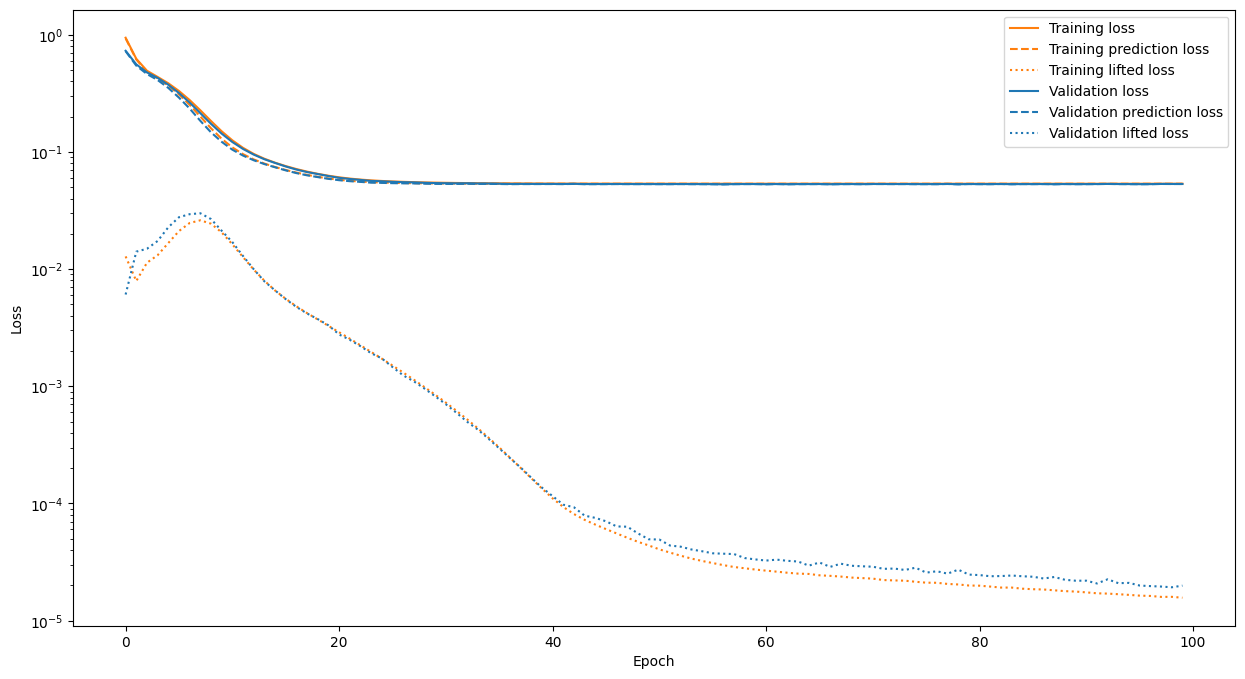

In [18]:
train_loss = [l[0] for l in model_koop_dnn.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn.val_loss_hist]
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.savefig("convergence plot for arch1")
plt.show()


In [19]:
map_net_params = {}
map_net_params["input_dim"] = int(num_joints) #number of joint angles
map_net_params["output_dim"] = X_end.shape[2] #x and y position of the end effector
map_net_params["hidden_width"] = 20 #20
map_net_params["hidden_depth"] = 4  #2
map_net_params["batch_size"] = 128  #100
map_net_params["epochs"] = 200     # 500
map_net_params["activation_type"] = 'tanh'
map_net_params["lr"] = 1e-3     #1e-3
map_net_params["optimizer"] = 'adam'
map_net_params['l2_reg'] = 0.0
map_net_params['l1_reg'] = 0.0

In [20]:
#dataset
# split training and vaidation datasets
xs_map_train, ys_map_train = X_fw[:num_train,:,:int(num_joints)],X_end_fw[:num_train,:,:num_inputs]
xs_map_val, ys_map_val = X_fw[num_train:,:,:int(num_joints)],X_end_fw[num_train:,:,:num_inputs]

In [21]:
ys_map_train.shape, ys_map_val.shape,xs_map_train.shape, xs_map_val.shape

((150, 1000, 3), (50, 1000, 3), (150, 1000, 5), (50, 1000, 5))

In [22]:
#Initalize network
#Initalize network
if mass_var == True:
    file_fwd = 'saved_models/'+ robot_type +'/map_net_con_mass_var.pth' 
else:
    file_fwd = 'saved_models/'+ robot_type +'/map_net_con.pth'

if train == True:
    map_net = map_Net(map_net_params)
    map_net.set_dataset_map(xs_map_train,ys_map_train,xs_map_val,ys_map_val)
    map_net.data_pipeline()
    torch.save(map_net,file_fwd)
else:
    map_net = torch.load(file_fwd)


Epoch   1: train loss: 0.0747115664, validation loss: 0.0425510626
Epoch   2: train loss: 0.0369075470, validation loss: 0.0311132412
Epoch   3: train loss: 0.0273343183, validation loss: 0.0241722947
Epoch   4: train loss: 0.0216242384, validation loss: 0.0192823863
Epoch   5: train loss: 0.0178531079, validation loss: 0.0164147588
Epoch   6: train loss: 0.0152927545, validation loss: 0.0145460236
Epoch   7: train loss: 0.0133699707, validation loss: 0.0121992895
Epoch   8: train loss: 0.0117590687, validation loss: 0.0110660321
Epoch   9: train loss: 0.0105481135, validation loss: 0.0106001888
Epoch  10: train loss: 0.0096271424, validation loss: 0.0092252565
Epoch  11: train loss: 0.0088917487, validation loss: 0.0084121570
Epoch  12: train loss: 0.0082805371, validation loss: 0.0080285570
Epoch  13: train loss: 0.0077436594, validation loss: 0.0075814696
Epoch  14: train loss: 0.0072440518, validation loss: 0.0085601681
Epoch  15: train loss: 0.0068169109, validation loss: 0.007277

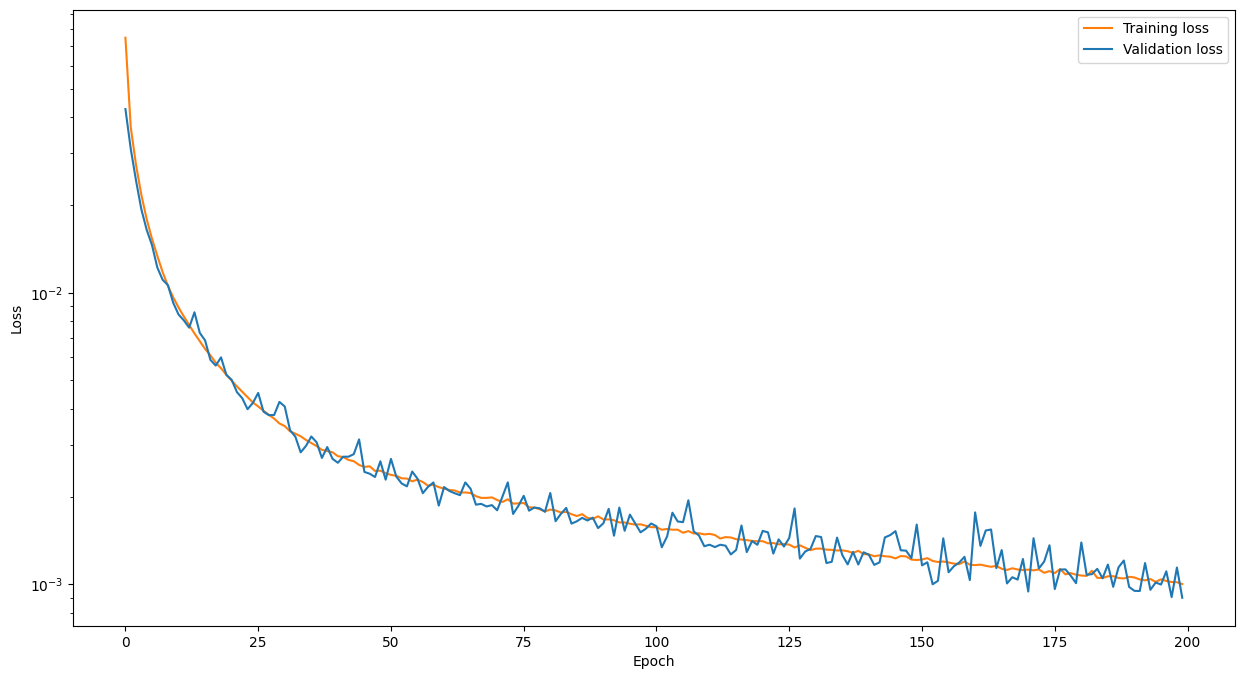

In [23]:
epochs = np.arange(0, map_net_params['epochs'])
plt.figure(figsize=(15,8))
plt.plot(epochs, map_net.train_loss_hist, color='tab:orange', label='Training loss')
plt.plot(epochs, map_net.val_loss_hist, color='tab:blue', label='Validation loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.savefig("convergence plot of map net for arch1[3,20,20,2]")
plt.show()

In [24]:
# # import scipy.io
# path_model = 'saved_models/'+ robot_type +'/matlab_files/' 

# #save net parameters
# scipy.io.savemat(path_model + "map_in_weights.mat", {"map_in_weights": map_net.map_net_in.weight.detach().numpy()})
# scipy.io.savemat(path_model + "map_in_bias.mat", {"map_in_bias": map_net.map_net_in.bias.detach().numpy()})

# scipy.io.savemat(path_model +"map_hidden_weights_1.mat",
#                  {"map_hidden_weights_1": map_net.map_net_hid[0].weight.detach().numpy()})
# scipy.io.savemat(path_model +"map_hidden_bias_1.mat",
#                  {"map_hidden_bias_1": map_net.map_net_hid[0].bias.detach().numpy()})

# scipy.io.savemat(path_model +"map_hidden_weights_2.mat",
#                  {"map_hidden_weights_2": map_net.map_net_hid[1].weight.detach().numpy()})
# scipy.io.savemat(path_model + "map_hidden_bias_2.mat",
#                  {"map_hidden_bias_2": map_net.map_net_hid[1].bias.detach().numpy()})

# scipy.io.savemat(path_model + "map_hidden_weights_3.mat",
#                  {"map_hidden_weights_3": map_net.map_net_hid[2].weight.detach().numpy()})
# scipy.io.savemat(path_model +"map_hidden_bias_3.mat",
#                  {"map_hidden_bias_3": map_net.map_net_hid[2].bias.detach().numpy()})

# scipy.io.savemat(path_model + "map_out_weights.mat", {"map_out_weights": map_net.map_net_out.weight.detach().numpy()})
# scipy.io.savemat(path_model + "map_out_bias.mat", {"map_out_bias": map_net.map_net_out.bias.detach().numpy()})

In [25]:
map_net.map_net_hid

ModuleList(
  (0-2): 3 x Linear(in_features=20, out_features=20, bias=True)
)

## Test Data Parameters

In [26]:
# test data parameters
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const 

***Koopman Bilinear Model***


In [27]:
A = np.array(model_koop_dnn.A)
#B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
B = np.array(model_koop_dnn.B)
#B_tensor = np.empty((num_inputs,n_obs, n_obs))
#for ii, b in enumerate(B):
    #B_tensor[ii] = b
C = np.array(model_koop_dnn.C)

print(A.shape, B.shape, C.shape)

(31, 31) (31, 5) (10, 31)


## Controlability

In [28]:
Ac = (A-np.eye(n_obs))/dt
Bc = B/dt
Cc = C
Cr = C[0:3,:]

Cr_v = C[num_joints:2*num_joints,:]


In [29]:
A.shape, B.shape

((31, 31), (31, 5))

In [30]:
#check controllability
Con_lin = ct.ctrb(Ac, Bc)
rank_lin = np.linalg.matrix_rank(Con_lin)

print(rank_lin)

30


In [31]:
out_con_mat, out_con_rank = Output_Con(Ac,Bc,Cc)


print(out_con_mat.shape)
print(out_con_rank)

(10, 160)
10


In [32]:
# continiouts
print('mean full',np.linalg.pinv(Bc).mean())
print('rank full',np.linalg.matrix_rank(Bc))

print('mean full',np.linalg.pinv(Ac).mean())
print('rank full',np.linalg.matrix_rank(Ac))

mean full 0.084325925
rank full 5
mean full 17.400217701392638
rank full 30


In [33]:
# continiouts
print('mean full',np.linalg.pinv(np.matmul(C,Bc)).mean(),np.linalg.pinv(np.matmul(C,Ac)).mean())
print('rank full',np.linalg.matrix_rank(np.matmul(C,Bc)), np.linalg.matrix_rank(np.matmul(C,Ac)))

print('mean reduced',np.linalg.pinv(np.matmul(Cr,Bc)).mean(),np.linalg.pinv(np.matmul(Cr,Ac)).mean())
print('rank reduced',np.linalg.matrix_rank(np.matmul(Cr,Bc)),np.linalg.matrix_rank(np.matmul(Cr,Ac)))

mean full 0.3926388 -0.06586931891529955
rank full 5 10
mean reduced -6154.2163 0.017037130844483543
rank reduced 3 3


In [34]:
# discreate
print('mean full',np.linalg.pinv(np.matmul(C,B)).mean(),np.linalg.pinv(np.matmul(C,A)).mean())
print('rank full',np.linalg.matrix_rank(np.matmul(C,B)), np.linalg.matrix_rank(np.matmul(C,A)))

print('mean reduced',np.linalg.pinv(np.matmul(Cr,B)).mean(),np.linalg.pinv(np.matmul(Cr,A)).mean())
print('rank reduced',np.linalg.matrix_rank(np.matmul(Cr,B)),np.linalg.matrix_rank(np.matmul(Cr,A)))

mean full 78.52777 0.032152202
rank full 5 10
mean reduced -1230843.4 0.032327563
rank reduced 3 3


In [35]:
print('mean full',np.linalg.pinv(np.matmul(C,B)).mean(),np.linalg.pinv(np.matmul(C,A)).mean())
print('rank full',np.linalg.matrix_rank(np.matmul(C,B)), np.linalg.matrix_rank(np.matmul(C,A)))

print('mean reduced',np.linalg.pinv(np.matmul(Cr_v,B)).mean(),np.linalg.pinv(np.matmul(Cr_v,A)).mean())
print('rank reduced',np.linalg.matrix_rank(np.matmul(Cr_v,B)),np.linalg.matrix_rank(np.matmul(Cr_v,A)))

mean full 78.52777 0.032152202
rank full 5 10
mean reduced 157.05936 0.03225075
rank reduced 5 5


In [36]:
# # #SAVE MATRIX PARAMETERS AS MATLAB FILE
# # import scipy.io

# dyn_matrices = {"A": A, "B": B, "C": C}
# scipy.io.savemat(path_model + "dyn_mat.mat", dyn_matrices)
# #save encoder parameters

# scipy.io.savemat(path_model + "in_weights.mat", {"encode_in_weights": model_koop_dnn.net.encoder_fc_in.weight.detach().numpy()})
# scipy.io.savemat(path_model + "in_bias.mat", {"encode_in_bias": model_koop_dnn.net.encoder_fc_in.bias.detach().numpy()})

# scipy.io.savemat(path_model + "hidden_weights_1.mat",
#                  {"encode_hidden_weights_1": model_koop_dnn.net.encoder_fc_hid[0].weight.detach().numpy()})
# scipy.io.savemat(path_model + "hidden_bias_1.mat",
#                  {"encode_hidden_bias_1": model_koop_dnn.net.encoder_fc_hid[0].bias.detach().numpy()})

# scipy.io.savemat(path_model + "hidden_weights_2.mat",
#                  {"encode_hidden_weights_2": model_koop_dnn.net.encoder_fc_hid[1].weight.detach().numpy()})
# scipy.io.savemat(path_model + "hidden_bias_2.mat",
#                  {"encode_hidden_bias_2": model_koop_dnn.net.encoder_fc_hid[1].bias.detach().numpy()})

# scipy.io.savemat(path_model + "out_weights.mat", {"encode_out_weights": model_koop_dnn.net.encoder_fc_out.weight.detach().numpy()})
# scipy.io.savemat(path_model + "out_bias.mat", {"encode_out_bias": model_koop_dnn.net.encoder_fc_out.bias.detach().numpy()})

# if standardize:
#     scipy.io.savemat(path_model + "std.mat", {"standardize": standardize, 'mean': standardizer_u_kdnn.mean_, 'scale':standardizer_u_kdnn.scale_})
    
# else:
#     scipy.io.savemat(path_model + "std.mat", {"standardize": standardize})

## Save Data

In [37]:
# #SAVE MATRIX PARAMETERS AS MATLAB FILE
# import scipy.io

path_model = 'saved_models/'+ robot_type +'/matlab_files/' 

dyn_matrices = {"A": A, "B": B, "C": C}
scipy.io.savemat(path_model + "dyn_mat.mat", dyn_matrices)
#save encoder parameters

encoder_dict = {}

encoder_dict["encoder_in_weights"] =  model_koop_dnn.net.encoder_fc_in.weight.detach().numpy()
encoder_dict["encoder_in_bias"] = model_koop_dnn.net.encoder_fc_in.bias.detach().numpy()
encoder_dict["encoder_hidden_depth"] = int(net_params["encoder_hidden_depth"]-1) 

encoder_dict["encoder_hidden_weights"] = np.empty((net_params["encoder_hidden_width"],net_params["encoder_hidden_width"],net_params["encoder_hidden_depth"]-1))
encoder_dict["encoder_hidden_bias"] = np.empty((1,net_params["encoder_hidden_width"],net_params["encoder_hidden_depth"]-1))


for i in range(net_params["encoder_hidden_depth"]-1):
    
    encoder_dict["encoder_hidden_weights"][:,:,i] = model_koop_dnn.net.encoder_fc_hid[i].weight.detach().numpy()
    encoder_dict["encoder_hidden_bias"][:,:,i] = model_koop_dnn.net.encoder_fc_hid[i].bias.detach().numpy()

encoder_dict["encoder_out_weights"] = model_koop_dnn.net.encoder_fc_out.weight.detach().numpy()
encoder_dict["encoder_out_bias"] = model_koop_dnn.net.encoder_fc_out.bias.detach().numpy()

scipy.io.savemat(path_model + "encoder.mat", encoder_dict)

if standardize:
    scipy.io.savemat(path_model + "std.mat", {"standardize": standardize, 'mean': standardizer_u_kdnn.mean_, 'scale':standardizer_u_kdnn.scale_})
    
else:
    scipy.io.savemat(path_model + "std.mat", {"standardize": standardize})

In [38]:
# save forward map
forward_map_dict = {}

forward_map_dict["map_in_weights"] = map_net.map_net_in.weight.detach().numpy()
forward_map_dict["map_in_bias"] = map_net.map_net_in.bias.detach().numpy()
forward_map_dict["map_hidden_depth"] = int(map_net_params["hidden_depth"]-1)

forward_map_dict["map_hidden_weights"] = np.empty((map_net_params["hidden_width"],map_net_params["hidden_width"],map_net_params["hidden_depth"]-1))
forward_map_dict["map_hidden_bias"] = np.empty((1,map_net_params["hidden_width"],map_net_params["hidden_depth"]-1))

for i in range(map_net_params["hidden_depth"]-1):
    
    forward_map_dict["map_hidden_weights"][:,:,i] = map_net.map_net_hid[i].weight.detach().numpy()
    forward_map_dict["map_hidden_bias"][:,:,i] = map_net.map_net_hid[i].bias.detach().numpy()

forward_map_dict["map_out_weights"] = map_net.map_net_out.weight.detach().numpy()
forward_map_dict["map_out_bias"] = map_net.map_net_out.bias.detach().numpy()


path_model = 'saved_models/'+ robot_type +'/matlab_files/' 
#save net parameters


scipy.io.savemat(path_model + "forward_map.mat", forward_map_dict)


In [39]:
net_params['encoder_hidden_depth']

3

In [40]:
path_model

'saved_models/5R/linear/3D/matlab_files/'

In [41]:
encode_out_bias = model_koop_dnn.net.encoder_fc_out.bias.detach().numpy()
encode_out_weights = model_koop_dnn.net.encoder_fc_out.weight.detach().numpy()

***Test Data Generation***

In [42]:
test_data = 'dynamics/Dataset_MATLAB/' + robot_type_load +'/data_test.mat'
data_test = scipy.io.loadmat(test_data)

In [43]:
X_end_test = np.array(data_test['X_end'], dtype = 'float64')
X_test = np.array(data_test['X'], dtype = 'float64')
U_test = np.array(data_test['tau'], dtype = 'float64')
num_snaps_test = int(data_test['num_snaps'])
num_traj_test = int(data_test['num_traj'])
# test data parameters
T = np.linspace(0,num_snaps_test*dt, num_snaps_test+1)

In [44]:
# data_gen
j = random.choice(range(num_traj_test))
xs_end_test = X_end_test[j,:,:]
xs_test = X_test[j,:,:]
us_test = U_test[j,:,:]

In [45]:
print(xs_end_test.shape, xs_test.shape, us_test.shape)

(1001, 3) (1001, 10) (1000, 5)


In [46]:
print(model_koop_dnn.test_loss(xs_test.reshape(1,-1,num_states),u_test = us_test.reshape(1,-1,num_inputs)))

tensor(0.0487)


In [47]:
basis = model_koop_dnn.net.encode_forward_

In [48]:
X,_ = model_koop_dnn.net.process(xs_test.reshape(1,-1,num_states),data_u = us_test.reshape(1,-1,num_inputs))
print(X.shape)

(1000, 25)


In [49]:
x = X[:, :num_states]
u = X[:, num_states:num_states+num_inputs]
x_prime = X[:,num_states+num_inputs:]

print(x.shape, u.shape, x_prime.shape)

(1000, 10) (1000, 5) (1000, 10)


***Initial Condition Lifting***

In [50]:
# initialize the matricies
z = np.empty((n_obs,num_snaps_test+1)).T
x_est = np.zeros((num_states,num_snaps_test+1)).T
x_end_est = np.zeros((X_end.shape[2],num_snaps_test)).T

In [51]:
z[0,:] = lift(x[0,:],model_koop_dnn, net_params)
x_est[0,:] = x[0,:]

***Time Evolution***

In [52]:
for i in range(num_snaps_test):
  #bilinear
    z[i+1,:] = np.matmul(z[i,:],A.T)+np.matmul(u[i,:],B.T)
    x_est[i+1,:] = np.matmul(z[i+1,:],C.T)  
    x_end_est[i,:] = map_net.forward(torch.from_numpy(x_est[i,:int(num_joints)]).float()).detach().numpy()

***Visualization***

# Joint Space

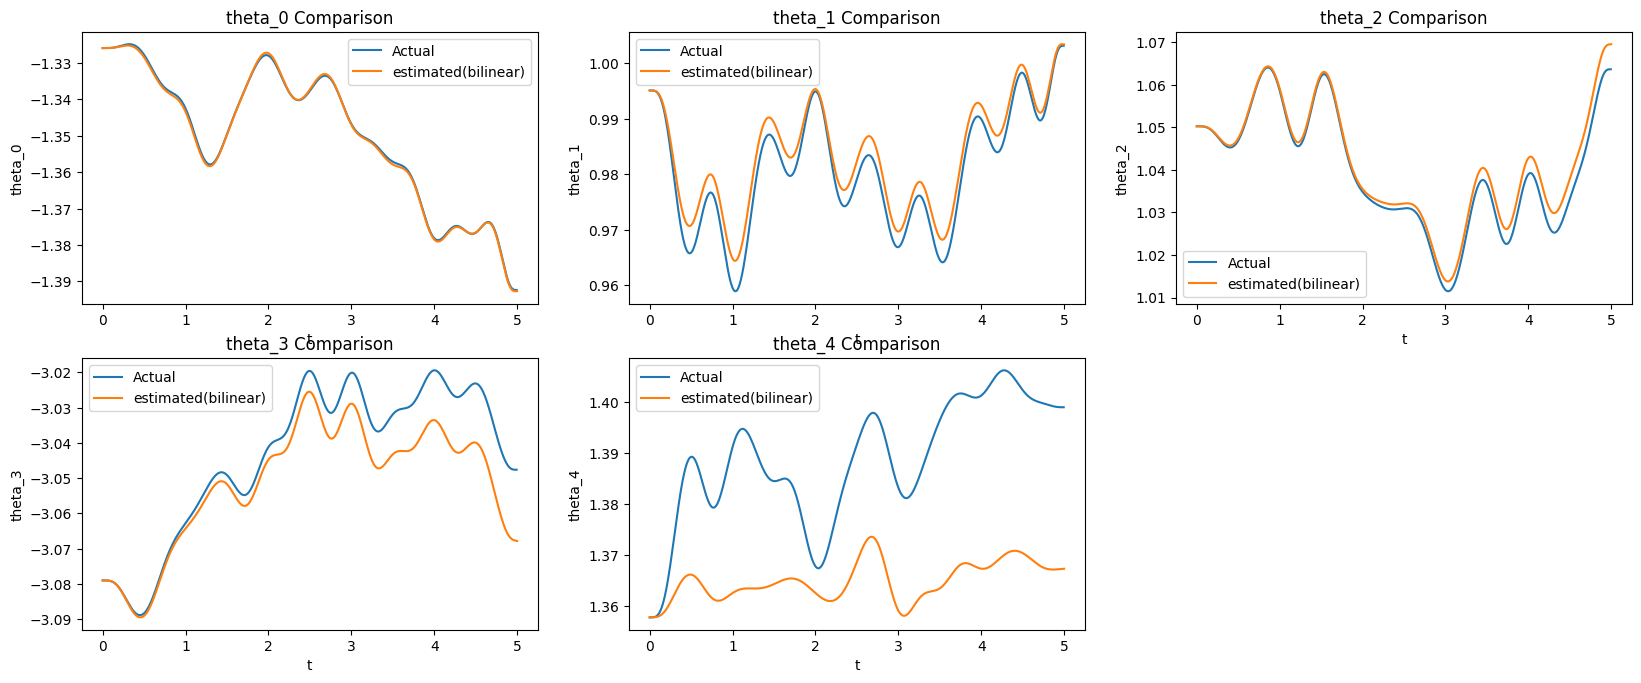

In [53]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(T[:-1],x[:,i],label ='Actual')
    plt.plot(T[:],x_est[:,i],label = 'estimated(bilinear)')
    plt.xlabel('t')
    plt.ylabel('theta_' + str(i))
    plt.title('theta_' + str(i) + ' Comparison')
    plt.legend()

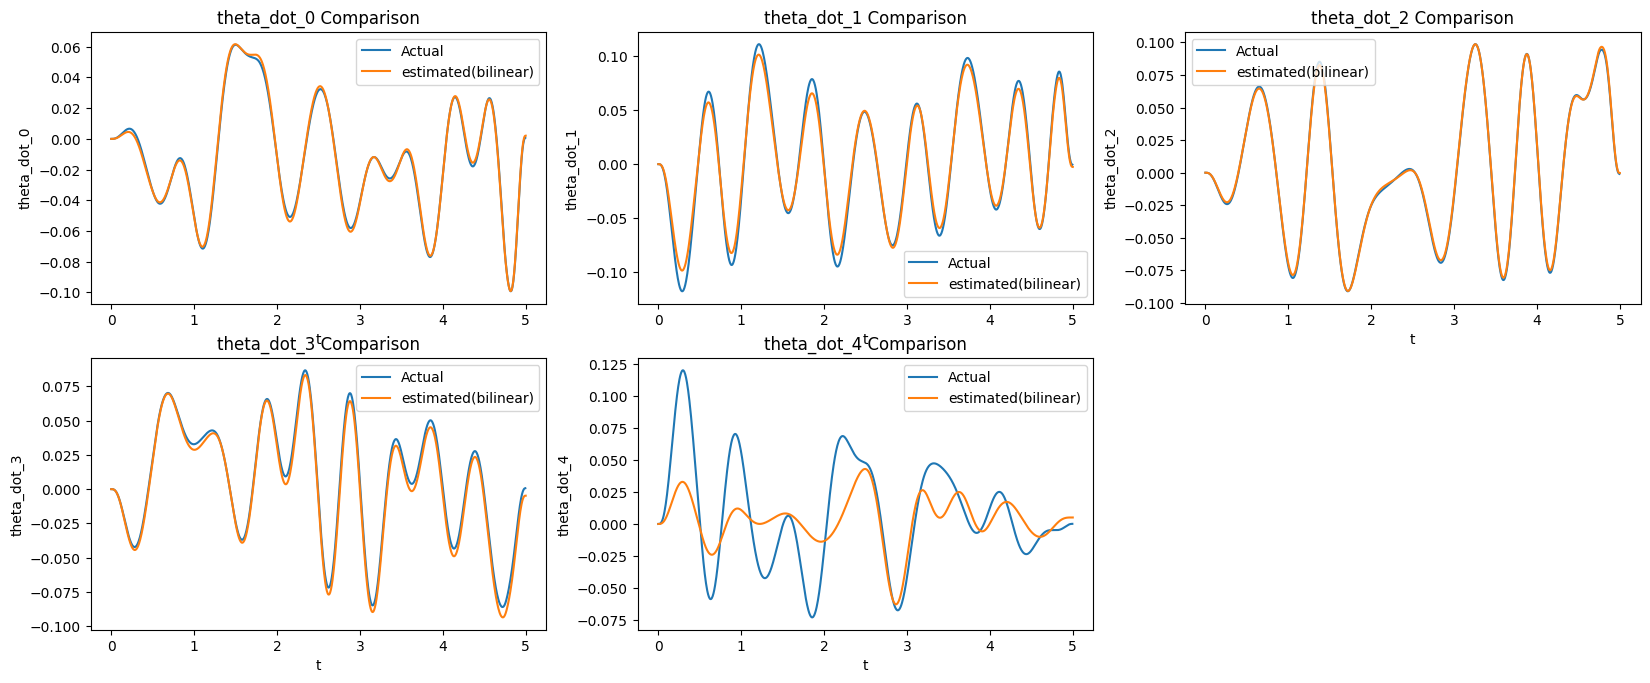

In [54]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(T[:-1],x[:,int(num_joints)+i],label ='Actual')
    plt.plot(T[:],x_est[:,int(num_joints)+i],label = 'estimated(bilinear)')
    plt.xlabel('t')
    plt.ylabel('theta_dot_' + str(i))
    plt.title('theta_dot_' + str(i) + ' Comparison')
    plt.legend()

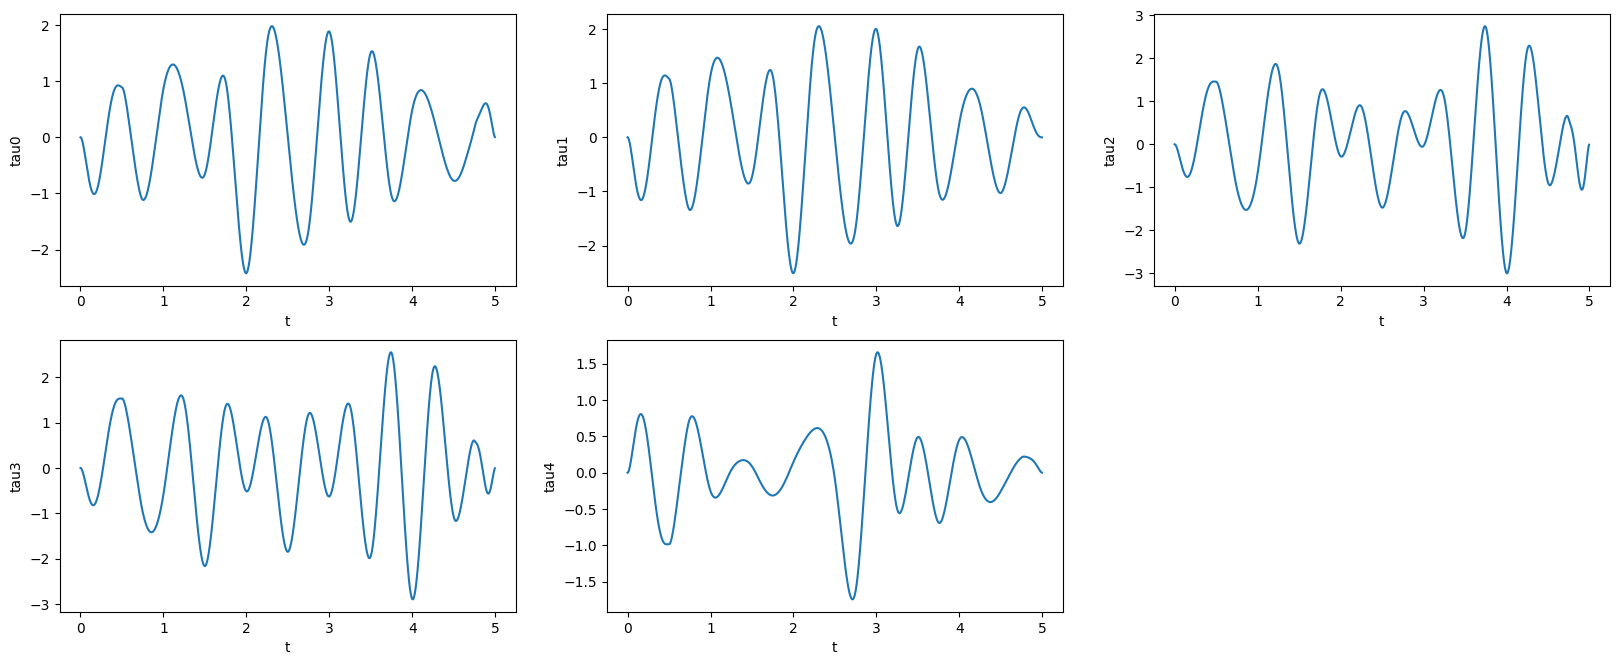

In [55]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(T[:-1],u[:,i])
    plt.xlabel('t')
    plt.ylabel('tau' + str(i))

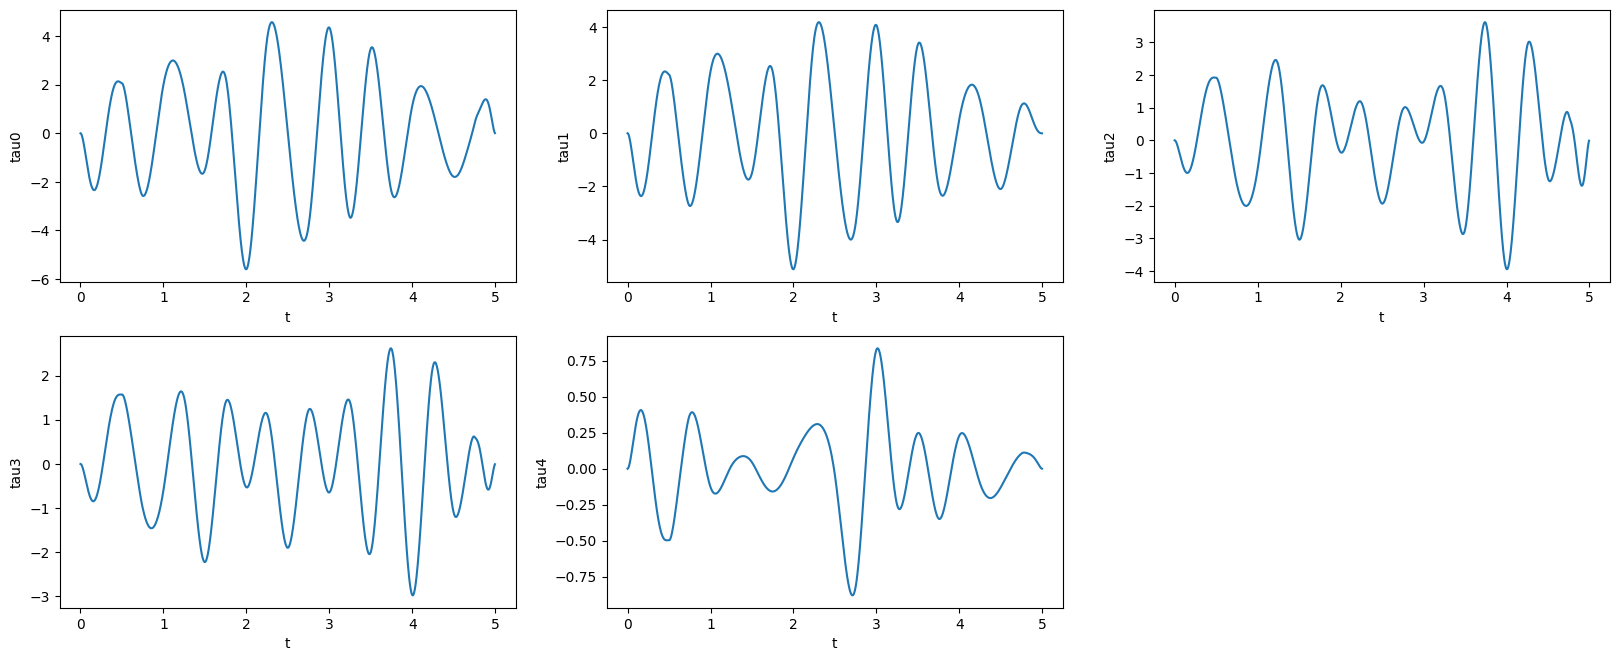

In [56]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(T[:-1],us_test[:,i])
    plt.xlabel('t')
    plt.ylabel('tau' + str(i))

(1000, 5)
(1000, 5)


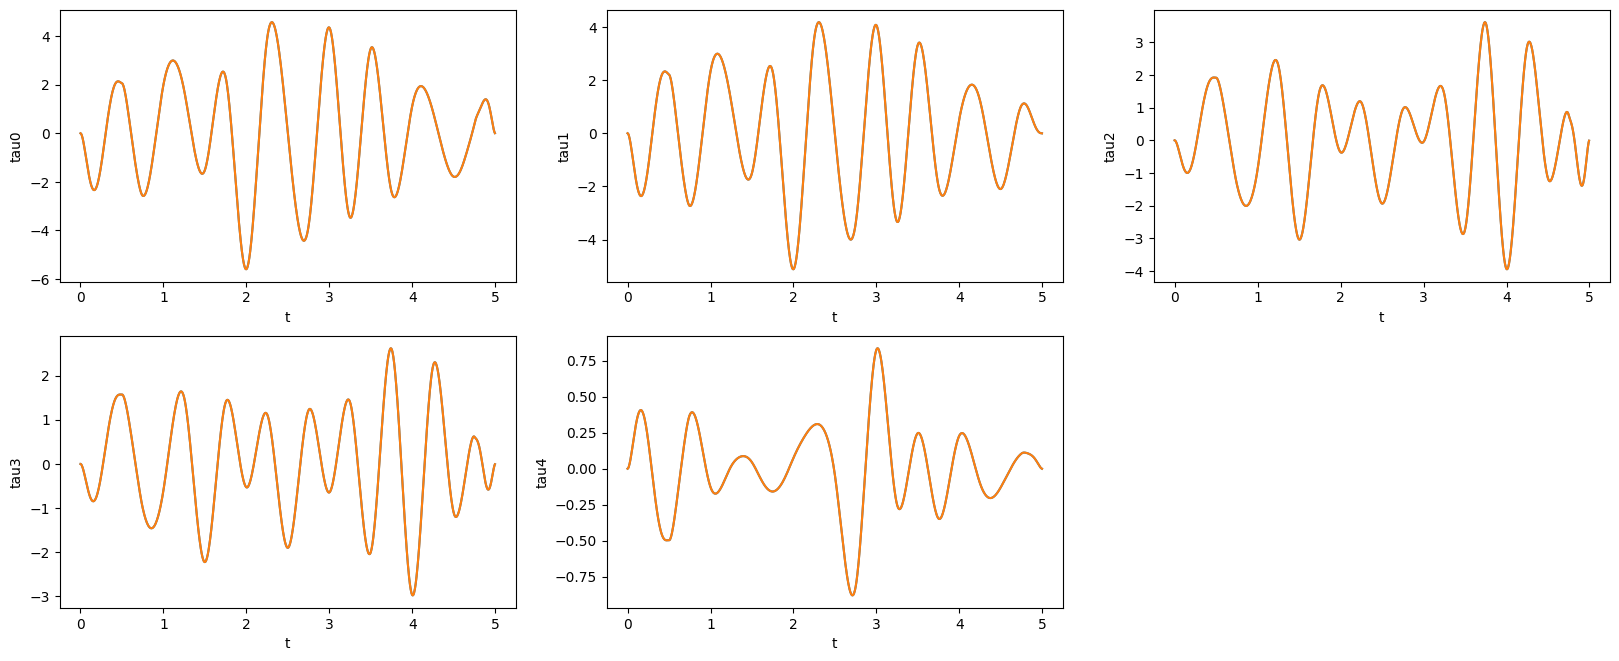

In [57]:
if standardize:
    u_unscaled = np.array([standardizer_u_kdnn.inverse_transform(d.reshape(1,-1)) for d in u]).reshape(num_snaps_test,num_inputs)
    plt.figure(figsize=(20,12))
    for i in range(int(num_joints)):
        plt.subplot(3,3,i+1)
        plt.plot(T[:-1],us_test[:,i], label= 'original')
        plt.plot(T[:-1],u_unscaled[:,i], label= 'unscaled')
        plt.xlabel('t')
        plt.ylabel('tau' + str(i))
        
    print(u.shape)
    print(u_unscaled.shape)

In [58]:
# the mean error for the whole test dataset
# the mean error for the whole test dataset
error_ang_traj =  np.empty((num_snaps_test))
error_vel_traj =  np.empty((num_snaps_test))

error_ang_total  = np.empty((num_traj_test))
error_vel_total  = np.empty((num_traj_test))
for j in range(num_traj_test):
    xs_test = X_test[j,:,:]
    us_test = U_test[j,:,:]
    X,_ = model_koop_dnn.net.process(xs_test.reshape(1,-1,num_states),data_u = us_test.reshape(1,-1,num_inputs))
    x = X[:, :num_states]
    u = X[:, num_states:num_states+num_inputs]
    x_prime = X[:,num_states+num_inputs:]
    z[0,:] = lift(x[0,:],model_koop_dnn, net_params)
    x_est[0,:] = x[0,:]
    
    for i in range(num_snaps_test):
        #bilinear
        z[i+1,:] = np.matmul(z[i,:],A.T)+np.matmul(u[i,:],B.T)
        x_est[i+1,:] = np.matmul(z[i+1,:],C.T)  
        error_ang_traj[i] = np.mean(abs(x_est[i,:num_joints] - x[i,:num_joints]))
        error_vel_traj[i] = np.mean(abs(x_est[i,num_joints:] - x[i,num_joints:]))
        
    error_ang_total[j] = np.mean(error_ang_traj)
    error_vel_total[j] = np.mean(error_vel_traj)
    

In [59]:
print("Mean Absolute Error for joint angles for testing data :", np.mean(error_ang_total))
print("Mean Absolute Error for joint velocity for testing data :", np.mean(error_vel_total))

Mean Absolute Error for joint angles for testing data : 0.008397329959284891
Mean Absolute Error for joint velocity for testing data : 0.00828785717445164


## Cartesian Space

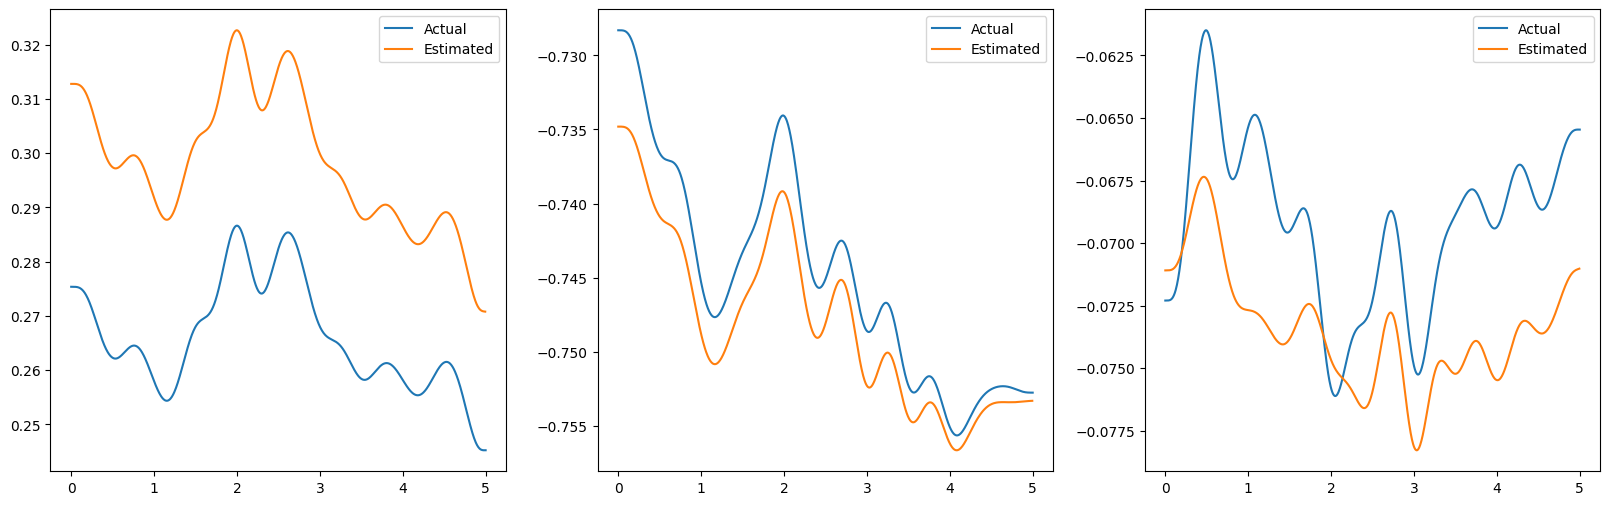

In [60]:
plt.figure(figsize=(20,6))
for i in range(X_end.shape[2]):
    plt.subplot(1,3,i+1)
    plt.plot(T[:],xs_end_test[:,i], label = 'Actual')
    plt.plot(T[:-1],x_end_est[:,i], label = 'Estimated')
    plt.legend()
plt.show()

In [61]:
error_joint_space = np.linalg.norm(xs_test-x_est,axis = 1)
error_cart_space = np.linalg.norm(xs_end_test[:-1]-x_end_est,axis = 1)

Text(0.5, 1.0, 'Cartesian Space Error')

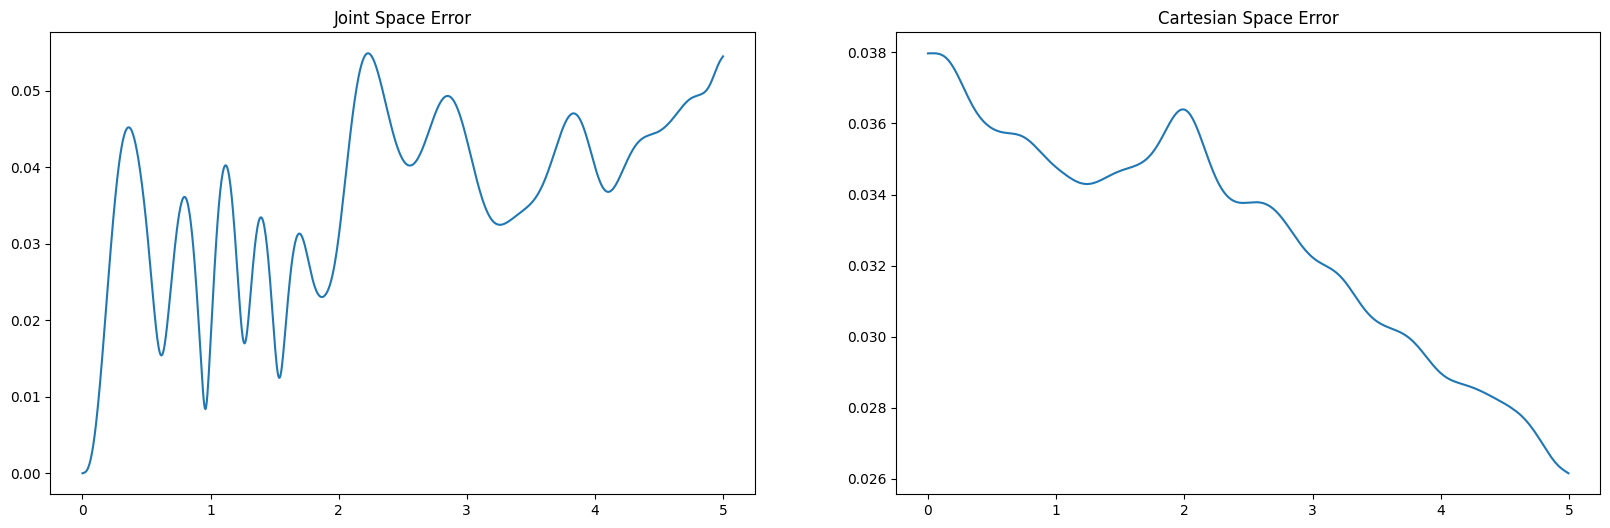

In [62]:
plt.figure(figsize =(20,6))
plt.subplot(1,2,1)
plt.plot(T[:],error_joint_space)
plt.title('Joint Space Error')

plt.subplot(1,2,2)
plt.plot(T[:-1],error_cart_space)
plt.title('Cartesian Space Error')

In [63]:
xs_test[8,:]

array([ 1.33950157e+00, -8.74669038e-01, -2.07835643e+00,  9.43878001e-01,
       -1.01941669e+00,  1.05337964e-04,  3.17770398e-05,  3.83946441e-04,
        1.53488112e-03, -8.88554417e-04])